In [1]:
import os
import time
import warnings

import google.auth
import numpy as np
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

from helpers import read_bigquery, write

warnings.filterwarnings('ignore')


class XGBAnalysis:
    def __init__(self):

        self.X_with_columns = read_bigquery('pp_X')
        self.X_with_columns = self.X_with_columns.loc[:, self.X_with_columns.columns != 'row_added']
        self.Z_with_columns = read_bigquery('pp_Z')
        self.Z_with_columns = self.Z_with_columns.loc[:, self.Z_with_columns.columns != 'row_added']
        columns_to_drop = []

        self.X_with_columns.drop(columns_to_drop, axis=1, inplace=True)
        self.Z_with_columns.drop(columns_to_drop, axis=1, inplace=True)

        self.X = np.array(self.X_with_columns)
        self.Y = read_bigquery('pp_Y').sort_values('index1').reset_index(drop=True)
        self.Y = np.array(self.Y.drop(['row_added', 'index1'], axis=1))

        self.Z = np.array(self.Z_with_columns)
        self.df_next_games = read_bigquery('pp_next_games_teams')

        self.credentials, self.project_id = google.auth.default()

    def upper_limits(self):
        print(' ')
        print('______________________________________________________________')

    def under_limits(self):
        print('______________________________________________________________')
        print(' ')

    def k_fold(self):
        kf = KFold(n_splits=4, random_state=0, shuffle=True)
        kf.get_n_splits(self.X)

        for train_index, test_index in kf.split(self.X):
            print("TRAIN:", train_index, "TEST:", test_index)
            X_train, X_test = self.X[train_index], self.X[test_index]
            y_train, y_test = self.Y[train_index], self.Y[test_index]

        return X_train, X_test, y_train, y_test

    def xgb_model(self):
        XGB_model = xgb.XGBClassifier(silent=False,
                                      learning_rate=0.01,
                                      colsample_bytree=0.5,
                                      subsample=0.8,
                                      objective='multi:softmax',
                                      n_estimators=1000,
                                      reg_alpha=0.1,
                                      reg_lambda=.4,
                                      max_depth=3,
                                      gamma=5,
                                      seed=82)

        return XGB_model

    def feature_importance(self, model):
        features_names = list(self.X_with_columns.columns)

        importance = np.round(model.feature_importances_, 4)
        dictionary = dict(zip(features_names, importance))
        sorted_dictionary = sorted(dictionary.items(), key=lambda x: x[1], reverse=True)
        names = []
        values = []

        self.upper_limits()
        for i in range(0, len(importance)):
            print('Feature Importance: {:35} {}%'.format(
                sorted_dictionary[i][0], np.round(sorted_dictionary[i][1] * 100, 4))
            )
            names.append(sorted_dictionary[i][0])
            values.append(np.round(sorted_dictionary[i][1] * 100, 4))
        self.under_limits()

    def xgb_predict(self, model):
        z_pred = model.predict(self.Z)
        xgb_df_next_games = self.df_next_games.copy()
        xgb_df_next_games['predicted_result'] = z_pred
        xgb_df_next_games['real_result'] = False

        return xgb_df_next_games

    def save_to_db(self, df):
        # write(df, self.project_id, 'statistics', 'xgb_next_games_pred', self.credentials)
        pass

    def xgb_fit_and_predict(self):
        X_train, X_test, y_train, y_test = self.k_fold()
        eval_set = [(X_train, y_train), (X_test, y_test)]
        XGB_model = self.xgb_model()

        XGB_model.fit(X_train, y_train, eval_metric=["merror", "mlogloss"], eval_set=eval_set, verbose=True)
        y_pred = XGB_model.predict(X_test)
        y_pred_train = XGB_model.predict(X_train)
        accuracy = accuracy_score(y_test, y_pred)
        accuracy_train = accuracy_score(y_train, y_pred_train)

        self.upper_limits()
        print("XGB train Accuracy: %.2f%%" % (accuracy_train * 100.0))
        print("XGB Accuracy: %.2f%%" % (accuracy * 100.0))
        self.under_limits()

        self.feature_importance(XGB_model)
        xgb_df_next_games = self.xgb_predict(XGB_model)
        xgb_df_next_games = xgb_df_next_games.iloc[::-1].reset_index(drop=True)

        df_all = read_bigquery('df_all_sorted')
        df_all = df_all.iloc[::-1].reset_index(drop=True)

        for index, row in xgb_df_next_games.iterrows():
            odds_home = df_all.loc[index]['odds_ft_home_team_win']
            odds_draw = df_all.loc[index]['odds_ft_draw']
            odds_away = df_all.loc[index]['odds_ft_away_team_win']

            xgb_df_next_games.at[index, 'odds_ft_home_team_win'] = odds_home
            xgb_df_next_games.at[index, 'odds_ft_draw'] = odds_draw
            xgb_df_next_games.at[index, 'odds_ft_away_team_win'] = odds_away

        print(xgb_df_next_games)
        os.environ['TZ'] = 'Europe/Amsterdam'
        time.tzset()
        xgb_df_next_games["date_time"] = time.strftime('%X %x %Z')
        xgb_df_next_games['id'] = xgb_df_next_games.index
        xgb_df_next_games['index'] = xgb_df_next_games.index
        xgb_df_next_games['real_result'] = xgb_df_next_games['real_result'].astype('Int64')

        self.upper_limits()
        print(xgb_df_next_games)
        self.under_limits()
        self.save_to_db(xgb_df_next_games)
        print(xgb_df_next_games)
        return xgb_df_next_games


In [2]:
pp = XGBAnalysis()
pp.xgb_fit_and_predict()

Downloading: 100%|██████████| 9/9 [00:00<00:00, 75.39rows/s]


TRAIN: [   0    2    3    4    6    7    9   11   12   13   16   17   19   20
   21   22   23   24   25   26   28   29   30   32   33   35   36   37
   38   40   41   42   43   46   47   48   50   51   53   54   56   57
   59   61   62   63   65   66   67   68   69   71   72   73   74   76
   77   78   79   80   81   83   84   86   87   88   89   90   91   93
   94   95   96   97   98   99  100  101  102  104  105  106  107  109
  110  111  112  114  115  116  117  118  119  120  121  123  125  126
  127  128  129  130  131  132  133  134  135  136  137  138  139  143
  144  145  146  147  148  149  150  151  153  154  155  157  158  160
  162  163  164  165  166  167  168  169  170  171  172  173  174  175
  176  177  178  179  180  181  182  183  185  188  189  190  191  193
  195  196  197  199  200  201  203  205  206  207  208  209  210  212
  213  214  215  216  217  218  219  220  221  222  223  225  226  227
  228  229  230  232  234  235  236  237  238  239  241  242  243  244

[1]	validation_0-merror:0.56302	validation_0-mlogloss:1.09757	validation_1-merror:0.52997	validation_1-mlogloss:1.09777
[2]	validation_0-merror:0.56723	validation_0-mlogloss:1.09711	validation_1-merror:0.52997	validation_1-mlogloss:1.09739
[3]	validation_0-merror:0.56092	validation_0-mlogloss:1.09654	validation_1-merror:0.53628	validation_1-mlogloss:1.09696
[4]	validation_0-merror:0.55672	validation_0-mlogloss:1.09596	validation_1-merror:0.54890	validation_1-mlogloss:1.09659
[5]	validation_0-merror:0.56092	validation_0-mlogloss:1.09540	validation_1-merror:0.54574	validation_1-mlogloss:1.09625
[6]	validation_0-merror:0.56828	validation_0-mlogloss:1.09486	validation_1-merror:0.53628	validation_1-mlogloss:1.09584
[7]	validation_0-merror:0.57248	validation_0-mlogloss:1.09432	validation_1-merror:0.53943	validation_1-mlogloss:1.09539
[8]	validation_0-merror:0.57353	validation_0-mlogloss:1.09398	validation_1-merror:0.53943	validation_1-mlogloss:1.09507
[9]	validation_0-merror:0.56723	validati

[69]	validation_0-merror:0.57773	validation_0-mlogloss:1.07255	validation_1-merror:0.53943	validation_1-mlogloss:1.08027
[70]	validation_0-merror:0.57773	validation_0-mlogloss:1.07248	validation_1-merror:0.53628	validation_1-mlogloss:1.08011
[71]	validation_0-merror:0.57668	validation_0-mlogloss:1.07216	validation_1-merror:0.53943	validation_1-mlogloss:1.07995
[72]	validation_0-merror:0.57668	validation_0-mlogloss:1.07184	validation_1-merror:0.53943	validation_1-mlogloss:1.07979
[73]	validation_0-merror:0.57668	validation_0-mlogloss:1.07149	validation_1-merror:0.53943	validation_1-mlogloss:1.07964
[74]	validation_0-merror:0.57773	validation_0-mlogloss:1.07130	validation_1-merror:0.53943	validation_1-mlogloss:1.07948
[75]	validation_0-merror:0.57878	validation_0-mlogloss:1.07116	validation_1-merror:0.53943	validation_1-mlogloss:1.07932
[76]	validation_0-merror:0.57878	validation_0-mlogloss:1.07106	validation_1-merror:0.53628	validation_1-mlogloss:1.07911
[77]	validation_0-merror:0.57773

[137]	validation_0-merror:0.57878	validation_0-mlogloss:1.05910	validation_1-merror:0.53312	validation_1-mlogloss:1.07203
[138]	validation_0-merror:0.57878	validation_0-mlogloss:1.05898	validation_1-merror:0.53628	validation_1-mlogloss:1.07187
[139]	validation_0-merror:0.57878	validation_0-mlogloss:1.05880	validation_1-merror:0.53628	validation_1-mlogloss:1.07184
[140]	validation_0-merror:0.57878	validation_0-mlogloss:1.05864	validation_1-merror:0.53628	validation_1-mlogloss:1.07183
[141]	validation_0-merror:0.57878	validation_0-mlogloss:1.05844	validation_1-merror:0.53628	validation_1-mlogloss:1.07168
[142]	validation_0-merror:0.57878	validation_0-mlogloss:1.05825	validation_1-merror:0.53628	validation_1-mlogloss:1.07157
[143]	validation_0-merror:0.57878	validation_0-mlogloss:1.05822	validation_1-merror:0.53628	validation_1-mlogloss:1.07149
[144]	validation_0-merror:0.57878	validation_0-mlogloss:1.05793	validation_1-merror:0.53628	validation_1-mlogloss:1.07143
[145]	validation_0-merro

[205]	validation_0-merror:0.57668	validation_0-mlogloss:1.05017	validation_1-merror:0.53628	validation_1-mlogloss:1.06891
[206]	validation_0-merror:0.57668	validation_0-mlogloss:1.05016	validation_1-merror:0.53628	validation_1-mlogloss:1.06889
[207]	validation_0-merror:0.57668	validation_0-mlogloss:1.05007	validation_1-merror:0.53628	validation_1-mlogloss:1.06890
[208]	validation_0-merror:0.57668	validation_0-mlogloss:1.05005	validation_1-merror:0.53628	validation_1-mlogloss:1.06884
[209]	validation_0-merror:0.57668	validation_0-mlogloss:1.05004	validation_1-merror:0.53628	validation_1-mlogloss:1.06879
[210]	validation_0-merror:0.57668	validation_0-mlogloss:1.05003	validation_1-merror:0.53628	validation_1-mlogloss:1.06874
[211]	validation_0-merror:0.57668	validation_0-mlogloss:1.04977	validation_1-merror:0.53628	validation_1-mlogloss:1.06880
[212]	validation_0-merror:0.57668	validation_0-mlogloss:1.04976	validation_1-merror:0.53628	validation_1-mlogloss:1.06873
[213]	validation_0-merro

[273]	validation_0-merror:0.57563	validation_0-mlogloss:1.04383	validation_1-merror:0.53628	validation_1-mlogloss:1.06774
[274]	validation_0-merror:0.57563	validation_0-mlogloss:1.04373	validation_1-merror:0.53628	validation_1-mlogloss:1.06772
[275]	validation_0-merror:0.57563	validation_0-mlogloss:1.04360	validation_1-merror:0.53628	validation_1-mlogloss:1.06771
[276]	validation_0-merror:0.57563	validation_0-mlogloss:1.04347	validation_1-merror:0.53628	validation_1-mlogloss:1.06766
[277]	validation_0-merror:0.57563	validation_0-mlogloss:1.04321	validation_1-merror:0.53628	validation_1-mlogloss:1.06767
[278]	validation_0-merror:0.57563	validation_0-mlogloss:1.04320	validation_1-merror:0.53628	validation_1-mlogloss:1.06762
[279]	validation_0-merror:0.57563	validation_0-mlogloss:1.04320	validation_1-merror:0.53628	validation_1-mlogloss:1.06757
[280]	validation_0-merror:0.57563	validation_0-mlogloss:1.04302	validation_1-merror:0.53628	validation_1-mlogloss:1.06764
[281]	validation_0-merro

[341]	validation_0-merror:0.57143	validation_0-mlogloss:1.03721	validation_1-merror:0.53943	validation_1-mlogloss:1.06783
[342]	validation_0-merror:0.57143	validation_0-mlogloss:1.03702	validation_1-merror:0.53943	validation_1-mlogloss:1.06795
[343]	validation_0-merror:0.57143	validation_0-mlogloss:1.03690	validation_1-merror:0.53943	validation_1-mlogloss:1.06791
[344]	validation_0-merror:0.57143	validation_0-mlogloss:1.03690	validation_1-merror:0.53943	validation_1-mlogloss:1.06790
[345]	validation_0-merror:0.57248	validation_0-mlogloss:1.03676	validation_1-merror:0.53943	validation_1-mlogloss:1.06785
[346]	validation_0-merror:0.57248	validation_0-mlogloss:1.03676	validation_1-merror:0.53943	validation_1-mlogloss:1.06783
[347]	validation_0-merror:0.57248	validation_0-mlogloss:1.03665	validation_1-merror:0.53943	validation_1-mlogloss:1.06781
[348]	validation_0-merror:0.57248	validation_0-mlogloss:1.03665	validation_1-merror:0.53943	validation_1-mlogloss:1.06781
[349]	validation_0-merro

[409]	validation_0-merror:0.56828	validation_0-mlogloss:1.03362	validation_1-merror:0.53943	validation_1-mlogloss:1.06753
[410]	validation_0-merror:0.56828	validation_0-mlogloss:1.03350	validation_1-merror:0.53943	validation_1-mlogloss:1.06745
[411]	validation_0-merror:0.56828	validation_0-mlogloss:1.03350	validation_1-merror:0.53943	validation_1-mlogloss:1.06743
[412]	validation_0-merror:0.56828	validation_0-mlogloss:1.03341	validation_1-merror:0.53943	validation_1-mlogloss:1.06744
[413]	validation_0-merror:0.56828	validation_0-mlogloss:1.03342	validation_1-merror:0.53943	validation_1-mlogloss:1.06746
[414]	validation_0-merror:0.56828	validation_0-mlogloss:1.03329	validation_1-merror:0.53943	validation_1-mlogloss:1.06744
[415]	validation_0-merror:0.56828	validation_0-mlogloss:1.03329	validation_1-merror:0.53943	validation_1-mlogloss:1.06742
[416]	validation_0-merror:0.56828	validation_0-mlogloss:1.03329	validation_1-merror:0.53943	validation_1-mlogloss:1.06740
[417]	validation_0-merro

[477]	validation_0-merror:0.55882	validation_0-mlogloss:1.02959	validation_1-merror:0.53628	validation_1-mlogloss:1.06767
[478]	validation_0-merror:0.55882	validation_0-mlogloss:1.02959	validation_1-merror:0.53628	validation_1-mlogloss:1.06767
[479]	validation_0-merror:0.55882	validation_0-mlogloss:1.02959	validation_1-merror:0.53628	validation_1-mlogloss:1.06766
[480]	validation_0-merror:0.55672	validation_0-mlogloss:1.02948	validation_1-merror:0.53628	validation_1-mlogloss:1.06760
[481]	validation_0-merror:0.55777	validation_0-mlogloss:1.02941	validation_1-merror:0.53628	validation_1-mlogloss:1.06763
[482]	validation_0-merror:0.55777	validation_0-mlogloss:1.02941	validation_1-merror:0.53628	validation_1-mlogloss:1.06760
[483]	validation_0-merror:0.55777	validation_0-mlogloss:1.02933	validation_1-merror:0.53628	validation_1-mlogloss:1.06767
[484]	validation_0-merror:0.55777	validation_0-mlogloss:1.02927	validation_1-merror:0.53628	validation_1-mlogloss:1.06773
[485]	validation_0-merro

[545]	validation_0-merror:0.54412	validation_0-mlogloss:1.02415	validation_1-merror:0.53628	validation_1-mlogloss:1.06844
[546]	validation_0-merror:0.54412	validation_0-mlogloss:1.02415	validation_1-merror:0.53628	validation_1-mlogloss:1.06843
[547]	validation_0-merror:0.54412	validation_0-mlogloss:1.02402	validation_1-merror:0.53628	validation_1-mlogloss:1.06848
[548]	validation_0-merror:0.54412	validation_0-mlogloss:1.02402	validation_1-merror:0.53628	validation_1-mlogloss:1.06849
[549]	validation_0-merror:0.54412	validation_0-mlogloss:1.02402	validation_1-merror:0.53628	validation_1-mlogloss:1.06846
[550]	validation_0-merror:0.54412	validation_0-mlogloss:1.02381	validation_1-merror:0.53628	validation_1-mlogloss:1.06844
[551]	validation_0-merror:0.54412	validation_0-mlogloss:1.02381	validation_1-merror:0.53628	validation_1-mlogloss:1.06844
[552]	validation_0-merror:0.54412	validation_0-mlogloss:1.02378	validation_1-merror:0.53628	validation_1-mlogloss:1.06843
[553]	validation_0-merro

[613]	validation_0-merror:0.53887	validation_0-mlogloss:1.01998	validation_1-merror:0.53628	validation_1-mlogloss:1.06935
[614]	validation_0-merror:0.53887	validation_0-mlogloss:1.01990	validation_1-merror:0.53628	validation_1-mlogloss:1.06939
[615]	validation_0-merror:0.53887	validation_0-mlogloss:1.01990	validation_1-merror:0.53628	validation_1-mlogloss:1.06938
[616]	validation_0-merror:0.53887	validation_0-mlogloss:1.01978	validation_1-merror:0.53628	validation_1-mlogloss:1.06942
[617]	validation_0-merror:0.53887	validation_0-mlogloss:1.01978	validation_1-merror:0.53628	validation_1-mlogloss:1.06942
[618]	validation_0-merror:0.53887	validation_0-mlogloss:1.01978	validation_1-merror:0.53628	validation_1-mlogloss:1.06940
[619]	validation_0-merror:0.53887	validation_0-mlogloss:1.01978	validation_1-merror:0.53628	validation_1-mlogloss:1.06941
[620]	validation_0-merror:0.53887	validation_0-mlogloss:1.01978	validation_1-merror:0.53628	validation_1-mlogloss:1.06941
[621]	validation_0-merro

[681]	validation_0-merror:0.53677	validation_0-mlogloss:1.01715	validation_1-merror:0.53943	validation_1-mlogloss:1.06952
[682]	validation_0-merror:0.53677	validation_0-mlogloss:1.01715	validation_1-merror:0.53628	validation_1-mlogloss:1.06950
[683]	validation_0-merror:0.53571	validation_0-mlogloss:1.01715	validation_1-merror:0.53943	validation_1-mlogloss:1.06953
[684]	validation_0-merror:0.53571	validation_0-mlogloss:1.01715	validation_1-merror:0.53943	validation_1-mlogloss:1.06953
[685]	validation_0-merror:0.53571	validation_0-mlogloss:1.01715	validation_1-merror:0.53943	validation_1-mlogloss:1.06955
[686]	validation_0-merror:0.53571	validation_0-mlogloss:1.01716	validation_1-merror:0.53943	validation_1-mlogloss:1.06956
[687]	validation_0-merror:0.53571	validation_0-mlogloss:1.01715	validation_1-merror:0.53943	validation_1-mlogloss:1.06956
[688]	validation_0-merror:0.53466	validation_0-mlogloss:1.01712	validation_1-merror:0.53943	validation_1-mlogloss:1.06961
[689]	validation_0-merro

[749]	validation_0-merror:0.52311	validation_0-mlogloss:1.01418	validation_1-merror:0.53943	validation_1-mlogloss:1.07046
[750]	validation_0-merror:0.52521	validation_0-mlogloss:1.01403	validation_1-merror:0.53943	validation_1-mlogloss:1.07047
[751]	validation_0-merror:0.52311	validation_0-mlogloss:1.01396	validation_1-merror:0.53943	validation_1-mlogloss:1.07055
[752]	validation_0-merror:0.52416	validation_0-mlogloss:1.01370	validation_1-merror:0.53943	validation_1-mlogloss:1.07053
[753]	validation_0-merror:0.52416	validation_0-mlogloss:1.01370	validation_1-merror:0.53943	validation_1-mlogloss:1.07054
[754]	validation_0-merror:0.52416	validation_0-mlogloss:1.01370	validation_1-merror:0.53943	validation_1-mlogloss:1.07055
[755]	validation_0-merror:0.52206	validation_0-mlogloss:1.01348	validation_1-merror:0.53943	validation_1-mlogloss:1.07051
[756]	validation_0-merror:0.52206	validation_0-mlogloss:1.01343	validation_1-merror:0.53943	validation_1-mlogloss:1.07049
[757]	validation_0-merro

[817]	validation_0-merror:0.51681	validation_0-mlogloss:1.01074	validation_1-merror:0.53628	validation_1-mlogloss:1.07077
[818]	validation_0-merror:0.51576	validation_0-mlogloss:1.01056	validation_1-merror:0.53628	validation_1-mlogloss:1.07071
[819]	validation_0-merror:0.51576	validation_0-mlogloss:1.01056	validation_1-merror:0.53628	validation_1-mlogloss:1.07073
[820]	validation_0-merror:0.51576	validation_0-mlogloss:1.01056	validation_1-merror:0.53628	validation_1-mlogloss:1.07074
[821]	validation_0-merror:0.51576	validation_0-mlogloss:1.01056	validation_1-merror:0.53628	validation_1-mlogloss:1.07074
[822]	validation_0-merror:0.51576	validation_0-mlogloss:1.01044	validation_1-merror:0.53628	validation_1-mlogloss:1.07080
[823]	validation_0-merror:0.51576	validation_0-mlogloss:1.01044	validation_1-merror:0.53628	validation_1-mlogloss:1.07081
[824]	validation_0-merror:0.51471	validation_0-mlogloss:1.01006	validation_1-merror:0.53628	validation_1-mlogloss:1.07099
[825]	validation_0-merro

[885]	validation_0-merror:0.50630	validation_0-mlogloss:1.00752	validation_1-merror:0.53943	validation_1-mlogloss:1.07126
[886]	validation_0-merror:0.50630	validation_0-mlogloss:1.00752	validation_1-merror:0.53943	validation_1-mlogloss:1.07125
[887]	validation_0-merror:0.50630	validation_0-mlogloss:1.00752	validation_1-merror:0.54259	validation_1-mlogloss:1.07125
[888]	validation_0-merror:0.50630	validation_0-mlogloss:1.00752	validation_1-merror:0.53943	validation_1-mlogloss:1.07120
[889]	validation_0-merror:0.50420	validation_0-mlogloss:1.00739	validation_1-merror:0.53943	validation_1-mlogloss:1.07126
[890]	validation_0-merror:0.50525	validation_0-mlogloss:1.00739	validation_1-merror:0.53943	validation_1-mlogloss:1.07125
[891]	validation_0-merror:0.50420	validation_0-mlogloss:1.00728	validation_1-merror:0.53943	validation_1-mlogloss:1.07131
[892]	validation_0-merror:0.50420	validation_0-mlogloss:1.00728	validation_1-merror:0.53943	validation_1-mlogloss:1.07130
[893]	validation_0-merro

[953]	validation_0-merror:0.50105	validation_0-mlogloss:1.00394	validation_1-merror:0.53943	validation_1-mlogloss:1.07144
[954]	validation_0-merror:0.50000	validation_0-mlogloss:1.00375	validation_1-merror:0.53943	validation_1-mlogloss:1.07135
[955]	validation_0-merror:0.49790	validation_0-mlogloss:1.00364	validation_1-merror:0.53943	validation_1-mlogloss:1.07139
[956]	validation_0-merror:0.49790	validation_0-mlogloss:1.00353	validation_1-merror:0.53943	validation_1-mlogloss:1.07134
[957]	validation_0-merror:0.49580	validation_0-mlogloss:1.00332	validation_1-merror:0.53943	validation_1-mlogloss:1.07139
[958]	validation_0-merror:0.49580	validation_0-mlogloss:1.00332	validation_1-merror:0.53943	validation_1-mlogloss:1.07137
[959]	validation_0-merror:0.49685	validation_0-mlogloss:1.00321	validation_1-merror:0.53943	validation_1-mlogloss:1.07139
[960]	validation_0-merror:0.49685	validation_0-mlogloss:1.00321	validation_1-merror:0.53943	validation_1-mlogloss:1.07138
[961]	validation_0-merro

Downloading: 100%|██████████| 1278/1278 [00:00<00:00, 1314.96rows/s]

        home_team_name     away_team_name         row_added  predicted_result  \
0             Freiburg           Augsburg  2021-09-23-10-55               3.0   
1               Bochum          Stuttgart  2021-09-23-10-55               3.0   
2  Borussia M'gladbach  Borussia Dortmund  2021-09-23-10-55               3.0   
3         Union Berlin  Arminia Bielefeld  2021-09-23-10-55               3.0   
4           RB Leipzig         Hertha BSC  2021-09-23-10-55               2.0   
5           Hoffenheim          Wolfsburg  2021-09-23-10-55               1.0   
6  Eintracht Frankfurt               Köln  2021-09-23-10-55               3.0   
7     Bayer Leverkusen           Mainz 05  2021-09-23-10-55               1.0   
8       Greuther Fürth     Bayern München  2021-09-23-10-55               3.0   

   real_result  odds_ft_home_team_win  odds_ft_draw  odds_ft_away_team_win  
0        False                   1.87          3.90                   4.20  
1        False                   3.

,home_team_name,away_team_name,row_added,predicted_result,real_result,odds_ft_home_team_win,odds_ft_draw,odds_ft_away_team_win,date_time,id,index
0,Freiburg,Augsburg,2021-09-23-10-55,3.0,0,1.87,3.90,4.20,13:21:40 09/23/21 CEST,0,0
1,Bochum,Stuttgart,2021-09-23-10-55,3.0,0,3.00,3.65,2.35,13:21:40 09/23/21 CEST,1,1
2,Borussia M'gladbach,Borussia Dortmund,2021-09-23-10-55,3.0,0,3.95,4.15,1.87,13:21:40 09/23/21 CEST,2,2
3,Union Berlin,Arminia Bielefeld,2021-09-23-10-55,3.0,0,1.80,3.80,4.80,13:21:40 09/23/21 CEST,3,3
4,RB Leipzig,Hertha BSC,2021-09-23-10-55,2.0,0,1.39,5.25,8.25,13:21:40 09/23/21 CEST,4,4
5,Hoffenheim,Wolfsburg,2021-09-23-10-55,1.0,0,2.85,3.50,2.50,13:21:40 09/23/21 CEST,5,5
6,Eintracht Frankfurt,Köln,2021-09-23-10-55,3.0,0,2.05,3.90,3.55,13:21:40 09/23/21 CEST,6,6
7,Bayer Leverkusen,Mainz 05,2021-09-23-10-55,1.0,0,1.87,4.00,4.05,13:21:40 09/23/21 CEST,7,7
8,Greuther Fürth,Bayern München,2021-09-23-10-55,3.0,0,19.00,11.00,1.13,13:21:40 09/23/21 CEST,8,8


## Explore 

In [3]:
X_train, X_test, y_train, y_test=pp.k_fold()

TRAIN: [   0    2    3    4    6    7    9   11   12   13   16   17   19   20
   21   22   23   24   25   26   28   29   30   32   33   35   36   37
   38   40   41   42   43   46   47   48   50   51   53   54   56   57
   59   61   62   63   65   66   67   68   69   71   72   73   74   76
   77   78   79   80   81   83   84   86   87   88   89   90   91   93
   94   95   96   97   98   99  100  101  102  104  105  106  107  109
  110  111  112  114  115  116  117  118  119  120  121  123  125  126
  127  128  129  130  131  132  133  134  135  136  137  138  139  143
  144  145  146  147  148  149  150  151  153  154  155  157  158  160
  162  163  164  165  166  167  168  169  170  171  172  173  174  175
  176  177  178  179  180  181  182  183  185  188  189  190  191  193
  195  196  197  199  200  201  203  205  206  207  208  209  210  212
  213  214  215  216  217  218  219  220  221  222  223  225  226  227
  228  229  230  232  234  235  236  237  238  239  241  242  243  244

In [4]:
eval_set = [(X_train, y_train), (X_test, y_test)]
XGB_model = pp.xgb_model()
XGB_model.fit(X_train, y_train, eval_metric=["merror", "mlogloss"], eval_set=eval_set, verbose=True)
y_pred = XGB_model.predict(X_test)
y_pred_train = XGB_model.predict(X_train)
accuracy = accuracy_score(y_test, y_pred)
accuracy_train = accuracy_score(y_train, y_pred_train)

[13:21:40] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-merror:0.57563	validation_0-mlogloss:1.09813	validation_1-merror:0.52997	validation_1-mlogloss:1.09822
[1]	validation_0-merror:0.56302	validation_0-mlogloss:1.09757	validation_1-merror:0.52997	validation_1-mlogloss:1.09777
[2]	validation_0-merror:0.56723	validation_0-mlogloss:1.09711	validation_1-merror:0.52997	validation_1-mlogloss:1.09739
[3]	validation_0-merror:0.56092	validation_0-mlogloss:1.09654	validation_1-merror:0.53628	validation_1-mlogloss:1.09696
[4]	validation_0-merror:0.55672	validation_0-mlogloss:1.09596	validation_1-merror:0.54890	validation_1-mlogloss:1.09659
[5]	validation_0-merror:0.56092	validation_0

[65]	validation_0-merror:0.57773	validation_0-mlogloss:1.07361	validation_1-merror:0.53943	validation_1-mlogloss:1.08089
[66]	validation_0-merror:0.57773	validation_0-mlogloss:1.07349	validation_1-merror:0.53628	validation_1-mlogloss:1.08073
[67]	validation_0-merror:0.57773	validation_0-mlogloss:1.07334	validation_1-merror:0.53628	validation_1-mlogloss:1.08058
[68]	validation_0-merror:0.57773	validation_0-mlogloss:1.07287	validation_1-merror:0.53628	validation_1-mlogloss:1.08035
[69]	validation_0-merror:0.57773	validation_0-mlogloss:1.07255	validation_1-merror:0.53943	validation_1-mlogloss:1.08027
[70]	validation_0-merror:0.57773	validation_0-mlogloss:1.07248	validation_1-merror:0.53628	validation_1-mlogloss:1.08011
[71]	validation_0-merror:0.57668	validation_0-mlogloss:1.07216	validation_1-merror:0.53943	validation_1-mlogloss:1.07995
[72]	validation_0-merror:0.57668	validation_0-mlogloss:1.07184	validation_1-merror:0.53943	validation_1-mlogloss:1.07979
[73]	validation_0-merror:0.57668

[133]	validation_0-merror:0.57878	validation_0-mlogloss:1.05987	validation_1-merror:0.52997	validation_1-mlogloss:1.07227
[134]	validation_0-merror:0.57878	validation_0-mlogloss:1.05974	validation_1-merror:0.52997	validation_1-mlogloss:1.07217
[135]	validation_0-merror:0.57878	validation_0-mlogloss:1.05946	validation_1-merror:0.52997	validation_1-mlogloss:1.07215
[136]	validation_0-merror:0.57878	validation_0-mlogloss:1.05942	validation_1-merror:0.52997	validation_1-mlogloss:1.07206
[137]	validation_0-merror:0.57878	validation_0-mlogloss:1.05910	validation_1-merror:0.53312	validation_1-mlogloss:1.07203
[138]	validation_0-merror:0.57878	validation_0-mlogloss:1.05898	validation_1-merror:0.53628	validation_1-mlogloss:1.07187
[139]	validation_0-merror:0.57878	validation_0-mlogloss:1.05880	validation_1-merror:0.53628	validation_1-mlogloss:1.07184
[140]	validation_0-merror:0.57878	validation_0-mlogloss:1.05864	validation_1-merror:0.53628	validation_1-mlogloss:1.07183
[141]	validation_0-merro

[201]	validation_0-merror:0.57668	validation_0-mlogloss:1.05077	validation_1-merror:0.53628	validation_1-mlogloss:1.06892
[202]	validation_0-merror:0.57668	validation_0-mlogloss:1.05076	validation_1-merror:0.53628	validation_1-mlogloss:1.06889
[203]	validation_0-merror:0.57668	validation_0-mlogloss:1.05063	validation_1-merror:0.53628	validation_1-mlogloss:1.06892
[204]	validation_0-merror:0.57668	validation_0-mlogloss:1.05039	validation_1-merror:0.53628	validation_1-mlogloss:1.06885
[205]	validation_0-merror:0.57668	validation_0-mlogloss:1.05017	validation_1-merror:0.53628	validation_1-mlogloss:1.06891
[206]	validation_0-merror:0.57668	validation_0-mlogloss:1.05016	validation_1-merror:0.53628	validation_1-mlogloss:1.06889
[207]	validation_0-merror:0.57668	validation_0-mlogloss:1.05007	validation_1-merror:0.53628	validation_1-mlogloss:1.06890
[208]	validation_0-merror:0.57668	validation_0-mlogloss:1.05005	validation_1-merror:0.53628	validation_1-mlogloss:1.06884
[209]	validation_0-merro

[269]	validation_0-merror:0.57458	validation_0-mlogloss:1.04456	validation_1-merror:0.53628	validation_1-mlogloss:1.06750
[270]	validation_0-merror:0.57458	validation_0-mlogloss:1.04442	validation_1-merror:0.53628	validation_1-mlogloss:1.06746
[271]	validation_0-merror:0.57458	validation_0-mlogloss:1.04413	validation_1-merror:0.53628	validation_1-mlogloss:1.06769
[272]	validation_0-merror:0.57458	validation_0-mlogloss:1.04395	validation_1-merror:0.53628	validation_1-mlogloss:1.06770
[273]	validation_0-merror:0.57563	validation_0-mlogloss:1.04383	validation_1-merror:0.53628	validation_1-mlogloss:1.06774
[274]	validation_0-merror:0.57563	validation_0-mlogloss:1.04373	validation_1-merror:0.53628	validation_1-mlogloss:1.06772
[275]	validation_0-merror:0.57563	validation_0-mlogloss:1.04360	validation_1-merror:0.53628	validation_1-mlogloss:1.06771
[276]	validation_0-merror:0.57563	validation_0-mlogloss:1.04347	validation_1-merror:0.53628	validation_1-mlogloss:1.06766
[277]	validation_0-merro

[337]	validation_0-merror:0.57353	validation_0-mlogloss:1.03782	validation_1-merror:0.53943	validation_1-mlogloss:1.06778
[338]	validation_0-merror:0.57353	validation_0-mlogloss:1.03782	validation_1-merror:0.53943	validation_1-mlogloss:1.06775
[339]	validation_0-merror:0.57353	validation_0-mlogloss:1.03754	validation_1-merror:0.53943	validation_1-mlogloss:1.06769
[340]	validation_0-merror:0.57143	validation_0-mlogloss:1.03721	validation_1-merror:0.53943	validation_1-mlogloss:1.06785
[341]	validation_0-merror:0.57143	validation_0-mlogloss:1.03721	validation_1-merror:0.53943	validation_1-mlogloss:1.06783
[342]	validation_0-merror:0.57143	validation_0-mlogloss:1.03702	validation_1-merror:0.53943	validation_1-mlogloss:1.06795
[343]	validation_0-merror:0.57143	validation_0-mlogloss:1.03690	validation_1-merror:0.53943	validation_1-mlogloss:1.06791
[344]	validation_0-merror:0.57143	validation_0-mlogloss:1.03690	validation_1-merror:0.53943	validation_1-mlogloss:1.06790
[345]	validation_0-merro

[405]	validation_0-merror:0.56828	validation_0-mlogloss:1.03381	validation_1-merror:0.53943	validation_1-mlogloss:1.06742
[406]	validation_0-merror:0.56828	validation_0-mlogloss:1.03381	validation_1-merror:0.53943	validation_1-mlogloss:1.06743
[407]	validation_0-merror:0.56828	validation_0-mlogloss:1.03381	validation_1-merror:0.53943	validation_1-mlogloss:1.06741
[408]	validation_0-merror:0.56828	validation_0-mlogloss:1.03370	validation_1-merror:0.53943	validation_1-mlogloss:1.06749
[409]	validation_0-merror:0.56828	validation_0-mlogloss:1.03362	validation_1-merror:0.53943	validation_1-mlogloss:1.06753
[410]	validation_0-merror:0.56828	validation_0-mlogloss:1.03350	validation_1-merror:0.53943	validation_1-mlogloss:1.06745
[411]	validation_0-merror:0.56828	validation_0-mlogloss:1.03350	validation_1-merror:0.53943	validation_1-mlogloss:1.06743
[412]	validation_0-merror:0.56828	validation_0-mlogloss:1.03341	validation_1-merror:0.53943	validation_1-mlogloss:1.06744
[413]	validation_0-merro

[473]	validation_0-merror:0.56198	validation_0-mlogloss:1.03003	validation_1-merror:0.53628	validation_1-mlogloss:1.06747
[474]	validation_0-merror:0.56092	validation_0-mlogloss:1.02991	validation_1-merror:0.53628	validation_1-mlogloss:1.06763
[475]	validation_0-merror:0.55882	validation_0-mlogloss:1.02970	validation_1-merror:0.53628	validation_1-mlogloss:1.06768
[476]	validation_0-merror:0.55882	validation_0-mlogloss:1.02959	validation_1-merror:0.53628	validation_1-mlogloss:1.06766
[477]	validation_0-merror:0.55882	validation_0-mlogloss:1.02959	validation_1-merror:0.53628	validation_1-mlogloss:1.06767
[478]	validation_0-merror:0.55882	validation_0-mlogloss:1.02959	validation_1-merror:0.53628	validation_1-mlogloss:1.06767
[479]	validation_0-merror:0.55882	validation_0-mlogloss:1.02959	validation_1-merror:0.53628	validation_1-mlogloss:1.06766
[480]	validation_0-merror:0.55672	validation_0-mlogloss:1.02948	validation_1-merror:0.53628	validation_1-mlogloss:1.06760
[481]	validation_0-merro

[541]	validation_0-merror:0.54517	validation_0-mlogloss:1.02459	validation_1-merror:0.53628	validation_1-mlogloss:1.06833
[542]	validation_0-merror:0.54622	validation_0-mlogloss:1.02443	validation_1-merror:0.53628	validation_1-mlogloss:1.06840
[543]	validation_0-merror:0.54517	validation_0-mlogloss:1.02443	validation_1-merror:0.53628	validation_1-mlogloss:1.06842
[544]	validation_0-merror:0.54412	validation_0-mlogloss:1.02434	validation_1-merror:0.53628	validation_1-mlogloss:1.06844
[545]	validation_0-merror:0.54412	validation_0-mlogloss:1.02415	validation_1-merror:0.53628	validation_1-mlogloss:1.06844
[546]	validation_0-merror:0.54412	validation_0-mlogloss:1.02415	validation_1-merror:0.53628	validation_1-mlogloss:1.06843
[547]	validation_0-merror:0.54412	validation_0-mlogloss:1.02402	validation_1-merror:0.53628	validation_1-mlogloss:1.06848
[548]	validation_0-merror:0.54412	validation_0-mlogloss:1.02402	validation_1-merror:0.53628	validation_1-mlogloss:1.06849
[549]	validation_0-merro

[609]	validation_0-merror:0.53887	validation_0-mlogloss:1.02033	validation_1-merror:0.53628	validation_1-mlogloss:1.06899
[610]	validation_0-merror:0.53887	validation_0-mlogloss:1.02027	validation_1-merror:0.53628	validation_1-mlogloss:1.06904
[611]	validation_0-merror:0.53887	validation_0-mlogloss:1.02005	validation_1-merror:0.53628	validation_1-mlogloss:1.06923
[612]	validation_0-merror:0.53887	validation_0-mlogloss:1.01998	validation_1-merror:0.53628	validation_1-mlogloss:1.06938
[613]	validation_0-merror:0.53887	validation_0-mlogloss:1.01998	validation_1-merror:0.53628	validation_1-mlogloss:1.06935
[614]	validation_0-merror:0.53887	validation_0-mlogloss:1.01990	validation_1-merror:0.53628	validation_1-mlogloss:1.06939
[615]	validation_0-merror:0.53887	validation_0-mlogloss:1.01990	validation_1-merror:0.53628	validation_1-mlogloss:1.06938
[616]	validation_0-merror:0.53887	validation_0-mlogloss:1.01978	validation_1-merror:0.53628	validation_1-mlogloss:1.06942
[617]	validation_0-merro

[677]	validation_0-merror:0.53466	validation_0-mlogloss:1.01724	validation_1-merror:0.53943	validation_1-mlogloss:1.06951
[678]	validation_0-merror:0.53571	validation_0-mlogloss:1.01715	validation_1-merror:0.53943	validation_1-mlogloss:1.06951
[679]	validation_0-merror:0.53677	validation_0-mlogloss:1.01715	validation_1-merror:0.53943	validation_1-mlogloss:1.06951
[680]	validation_0-merror:0.53677	validation_0-mlogloss:1.01715	validation_1-merror:0.53943	validation_1-mlogloss:1.06951
[681]	validation_0-merror:0.53677	validation_0-mlogloss:1.01715	validation_1-merror:0.53943	validation_1-mlogloss:1.06952
[682]	validation_0-merror:0.53677	validation_0-mlogloss:1.01715	validation_1-merror:0.53628	validation_1-mlogloss:1.06950
[683]	validation_0-merror:0.53571	validation_0-mlogloss:1.01715	validation_1-merror:0.53943	validation_1-mlogloss:1.06953
[684]	validation_0-merror:0.53571	validation_0-mlogloss:1.01715	validation_1-merror:0.53943	validation_1-mlogloss:1.06953
[685]	validation_0-merro

[745]	validation_0-merror:0.52416	validation_0-mlogloss:1.01440	validation_1-merror:0.53943	validation_1-mlogloss:1.07032
[746]	validation_0-merror:0.52311	validation_0-mlogloss:1.01430	validation_1-merror:0.53943	validation_1-mlogloss:1.07034
[747]	validation_0-merror:0.52311	validation_0-mlogloss:1.01418	validation_1-merror:0.53943	validation_1-mlogloss:1.07044
[748]	validation_0-merror:0.52311	validation_0-mlogloss:1.01418	validation_1-merror:0.53943	validation_1-mlogloss:1.07045
[749]	validation_0-merror:0.52311	validation_0-mlogloss:1.01418	validation_1-merror:0.53943	validation_1-mlogloss:1.07046
[750]	validation_0-merror:0.52521	validation_0-mlogloss:1.01403	validation_1-merror:0.53943	validation_1-mlogloss:1.07047
[751]	validation_0-merror:0.52311	validation_0-mlogloss:1.01396	validation_1-merror:0.53943	validation_1-mlogloss:1.07055
[752]	validation_0-merror:0.52416	validation_0-mlogloss:1.01370	validation_1-merror:0.53943	validation_1-mlogloss:1.07053
[753]	validation_0-merro

[813]	validation_0-merror:0.51786	validation_0-mlogloss:1.01088	validation_1-merror:0.53628	validation_1-mlogloss:1.07073
[814]	validation_0-merror:0.51786	validation_0-mlogloss:1.01088	validation_1-merror:0.53628	validation_1-mlogloss:1.07072
[815]	validation_0-merror:0.51681	validation_0-mlogloss:1.01074	validation_1-merror:0.53628	validation_1-mlogloss:1.07077
[816]	validation_0-merror:0.51681	validation_0-mlogloss:1.01074	validation_1-merror:0.53628	validation_1-mlogloss:1.07077
[817]	validation_0-merror:0.51681	validation_0-mlogloss:1.01074	validation_1-merror:0.53628	validation_1-mlogloss:1.07077
[818]	validation_0-merror:0.51576	validation_0-mlogloss:1.01056	validation_1-merror:0.53628	validation_1-mlogloss:1.07071
[819]	validation_0-merror:0.51576	validation_0-mlogloss:1.01056	validation_1-merror:0.53628	validation_1-mlogloss:1.07073
[820]	validation_0-merror:0.51576	validation_0-mlogloss:1.01056	validation_1-merror:0.53628	validation_1-mlogloss:1.07074
[821]	validation_0-merro

[881]	validation_0-merror:0.50630	validation_0-mlogloss:1.00763	validation_1-merror:0.53943	validation_1-mlogloss:1.07117
[882]	validation_0-merror:0.50630	validation_0-mlogloss:1.00763	validation_1-merror:0.53943	validation_1-mlogloss:1.07116
[883]	validation_0-merror:0.50630	validation_0-mlogloss:1.00752	validation_1-merror:0.53943	validation_1-mlogloss:1.07127
[884]	validation_0-merror:0.50630	validation_0-mlogloss:1.00752	validation_1-merror:0.53943	validation_1-mlogloss:1.07126
[885]	validation_0-merror:0.50630	validation_0-mlogloss:1.00752	validation_1-merror:0.53943	validation_1-mlogloss:1.07126
[886]	validation_0-merror:0.50630	validation_0-mlogloss:1.00752	validation_1-merror:0.53943	validation_1-mlogloss:1.07125
[887]	validation_0-merror:0.50630	validation_0-mlogloss:1.00752	validation_1-merror:0.54259	validation_1-mlogloss:1.07125
[888]	validation_0-merror:0.50630	validation_0-mlogloss:1.00752	validation_1-merror:0.53943	validation_1-mlogloss:1.07120
[889]	validation_0-merro

[949]	validation_0-merror:0.50210	validation_0-mlogloss:1.00452	validation_1-merror:0.53628	validation_1-mlogloss:1.07133
[950]	validation_0-merror:0.50210	validation_0-mlogloss:1.00425	validation_1-merror:0.53628	validation_1-mlogloss:1.07141
[951]	validation_0-merror:0.50210	validation_0-mlogloss:1.00425	validation_1-merror:0.53628	validation_1-mlogloss:1.07141
[952]	validation_0-merror:0.50105	validation_0-mlogloss:1.00406	validation_1-merror:0.53943	validation_1-mlogloss:1.07139
[953]	validation_0-merror:0.50105	validation_0-mlogloss:1.00394	validation_1-merror:0.53943	validation_1-mlogloss:1.07144
[954]	validation_0-merror:0.50000	validation_0-mlogloss:1.00375	validation_1-merror:0.53943	validation_1-mlogloss:1.07135
[955]	validation_0-merror:0.49790	validation_0-mlogloss:1.00364	validation_1-merror:0.53943	validation_1-mlogloss:1.07139
[956]	validation_0-merror:0.49790	validation_0-mlogloss:1.00353	validation_1-merror:0.53943	validation_1-mlogloss:1.07134
[957]	validation_0-merro

In [6]:
import pandas as pd
pd.Series(y_pred).value_counts()

3.0    298
1.0     18
2.0      1
dtype: int64

In [7]:
accuracy

0.4605678233438486

In [8]:
accuracy_train

0.5052521008403361

In [9]:
from sklearn.linear_model import LogisticRegression


LR = LogisticRegression(random_state = 42)
LR.fit(X_train, y_train)
LR_y_pred = LR.predict(X_test)
LR_y_pred_train = LR.predict(X_train)
LR_accuracy = accuracy_score(y_test, LR_y_pred)
LR_accuracy_train = accuracy_score(y_train, LR_y_pred_train)

In [10]:
pd.Series(LR_y_pred).value_counts()

3.0    229
1.0     65
2.0     23
dtype: int64

In [11]:
LR_accuracy

0.4384858044164038

In [12]:
LR_accuracy_train

0.46008403361344535

In [13]:
print("XGB train Accuracy: %.2f%%" % (accuracy_train * 100.0))
print("XGB Accuracy: %.2f%%" % (accuracy * 100.0))
print("LR train Accuracy: %.2f%%" % (LR_accuracy_train * 100.0))
print("LR Accuracy: %.2f%%" % (LR_accuracy * 100.0))

XGB train Accuracy: 50.53%
XGB Accuracy: 46.06%
LR train Accuracy: 46.01%
LR Accuracy: 43.85%


In [14]:
features_names = list(pp.X_with_columns.columns)

In [15]:
features_names

['Pre_Match_PPG__Home_',
 'Pre_Match_PPG__Away_',
 'attendance',
 'home_ppg',
 'away_ppg',
 'average_goals_per_match_pre_match',
 'btts_percentage_pre_match',
 'over_15_percentage_pre_match',
 'over_25_percentage_pre_match',
 'over_35_percentage_pre_match',
 'over_45_percentage_pre_match',
 'over_15_HT_FHG_percentage_pre_match',
 'over_05_HT_FHG_percentage_pre_match',
 'average_corners_per_match_pre_match',
 'average_cards_per_match_pre_match',
 'odds_ft_home_team_win',
 'odds_ft_draw',
 'odds_ft_away_team_win',
 'odds_ft_over15',
 'odds_ft_over25',
 'odds_ft_over35',
 'odds_ft_over45',
 'odds_btts_yes',
 'odds_btts_no',
 'ht_aa_0',
 'ht_aa_1',
 'ht_aa_2',
 'ht_aa_3',
 'ht_aa_4',
 'awt_aa_0',
 'awt_aa_1',
 'awt_aa_2',
 'awt_aa_3',
 'awt_aa_4',
 'AVGHTGDIFF',
 'AVGATGDIFF',
 'H_result_1',
 'H_result_2',
 'A_result_1',
 'A_result_2',
 'H_HTGDIFF_1',
 'H_HTGDIFF_2',
 'A_ATGDIFF_1',
 'A_ATGDIFF_2',
 'H_AVGHTGDIFF_1',
 'H_AVGHTGDIFF_2',
 'A_AVGATGDIFF_1',
 'A_AVGATGDIFF_2']

In [16]:
importance = np.round(XGB_model.feature_importances_,4)
dictionary = dict(zip(features_names, importance))
sorted_dictionary=sorted(dictionary.items(), key=lambda x:x[1], reverse=True)
names=[]
values=[]
for i in range(0, len(importance)):
    print('Feature Importance: {:35} {}%'.format(
        sorted_dictionary[i][0], np.round(sorted_dictionary[i][1]*100,4))
         )
    names.append(sorted_dictionary[i][0])
    values.append(np.round(sorted_dictionary[i][1]*100,4))

Feature Importance: ht_aa_2                             2.71%
Feature Importance: ht_aa_0                             2.65%
Feature Importance: awt_aa_2                            2.51%
Feature Importance: awt_aa_0                            2.47%
Feature Importance: H_result_1                          2.41%
Feature Importance: awt_aa_3                            2.32%
Feature Importance: over_35_percentage_pre_match        2.31%
Feature Importance: awt_aa_4                            2.29%
Feature Importance: odds_ft_home_team_win               2.28%
Feature Importance: H_AVGHTGDIFF_2                      2.27%
Feature Importance: btts_percentage_pre_match           2.25%
Feature Importance: away_ppg                            2.17%
Feature Importance: AVGHTGDIFF                          2.17%
Feature Importance: A_AVGATGDIFF_2                      2.17%
Feature Importance: over_05_HT_FHG_percentage_pre_match 2.16%
Feature Importance: average_goals_per_match_pre_match   2.13%
Feature 

In [17]:
cum_values = np.cumsum(values)
values_over_95 = (cum_values > 95).sum()
columns_over_95 = names[-values_over_95:]
columns_over_95

['awt_aa_1', 'odds_ft_over45', 'A_ATGDIFF_1', 'H_result_2']

In [23]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred, classes, labels,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    classes=classes
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    #plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             #rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [25]:
import seaborn as sns
sns.set(style='whitegrid', rc={'figure.figsize':(11.7,8.27)})
sns.set_context('talk', rc={ 'lines.linewidth': 6}, font_scale=1.5)

Normalized confusion matrix
[[0.94630872 0.05369128 0.        ]
 [0.94117647 0.04901961 0.00980392]
 [0.92424242 0.07575758 0.        ]]


<AxesSubplot:title={'center':'Confusion matrix, with normalization'}, xlabel='Predicted label', ylabel='True label'>

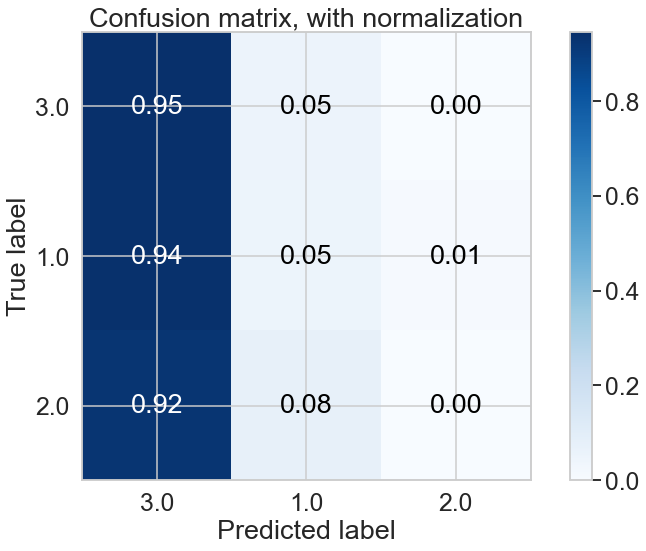

In [26]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=pd.Series(pp.Y.ravel()).unique(), labels=pd.Series(pp.Y.ravel()).unique(),
                      title='Confusion matrix, with normalization', normalize=True)

In [27]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix


def learning_curve(preds,y_test, model):
    predictions = [round(value) for value in preds]
    # evaluate predictions
    accuracy = accuracy_score(y_test, predictions)
    print("Accuracy: %.2f%%" % (accuracy * 100.0))
    # retrieve performance metrics
    results = model.evals_result()
    epochs = len(results['validation_0']['merror'])
    x_axis = range(0, epochs)
    # plot log loss
    fig, ax = pyplot.subplots()
    ax.plot(x_axis, results['validation_0']['merror'], label='Train')
    ax.plot(x_axis, results['validation_1']['merror'], label='Test')
    ax.legend()
    pyplot.ylabel('Log Loss')
    pyplot.title('XGBoost Log Loss')
    pyplot.show()
    # plot classification error
    fig, ax = pyplot.subplots()
    ax.plot(x_axis, results['validation_0']['merror'], label='Train')
    ax.plot(x_axis, results['validation_1']['merror'], label='Test')
    ax.legend()
    pyplot.ylabel('Classification Error')
    pyplot.title('XGBoost Classification Error')
    pyplot.show()

Accuracy: 46.06%


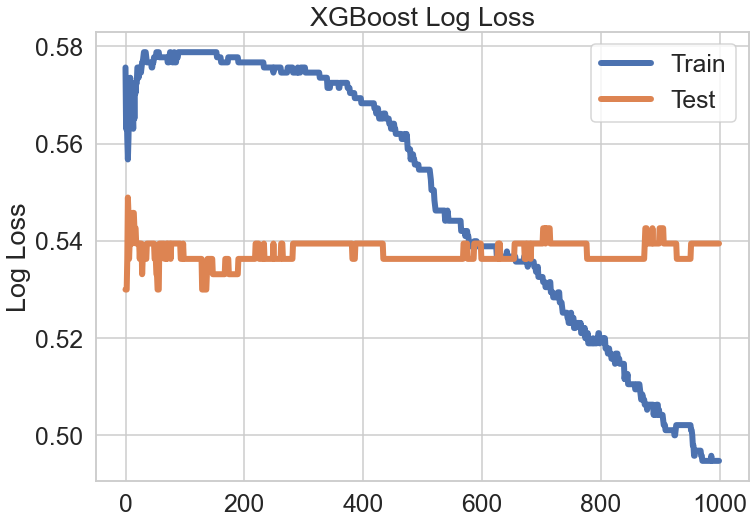

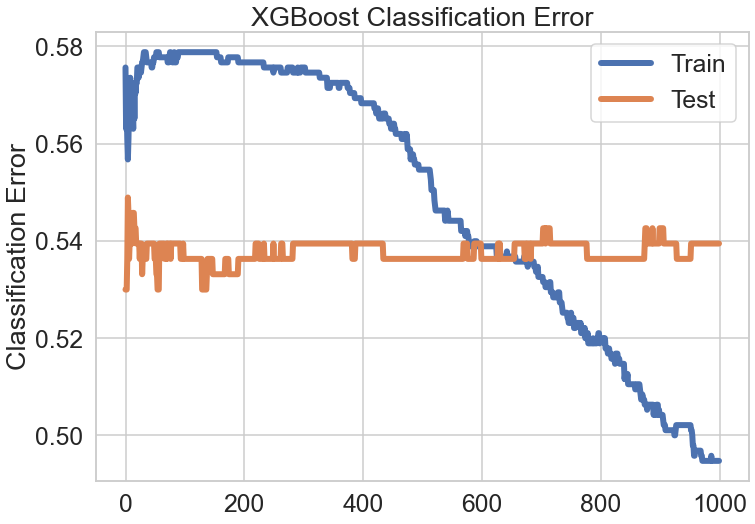

In [28]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import pyplot
learning_curve(y_pred,y_test,XGB_model)

## Gridsearch

In [29]:
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from matplotlib import pyplot

xgb = XGBClassifier(learning_rate=0.005, n_estimators=50, objective='multi:softprob',
                    silent=True, nthread=1, reg_alpha = 0.2, reg_lambda = .5, gamma=5)

In [38]:
params = {
        'learning_rate':[0.1,0.05,0.01, 0.005],
        'reg_alpha':[.1,.05,.001],
        'min_child_weight': [1, 5, 10,15],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5,6,7],
        'n_estimators': [400, 800, 1000],
        'early_stopping_rounds': [3,5,10]
        }

In [39]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import StratifiedKFold

folds = 4
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, n_jobs=5, cv=skf.split(pp.X,pp.Y), verbose=3, random_state=1001 )

In [40]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [41]:
from datetime import datetime

start_time = timer(None) # timing starts from this point for "start_time" variable
random_search.fit(pp.X, pp.Y)
timer(start_time) 

Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  18 out of  20 | elapsed:   27.4s remaining:    3.0s
[Parallel(n_jobs=5)]: Done  20 out of  20 | elapsed:   30.5s finished


[13:26:15] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { early_stopping_rounds, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.



 Time taken: 0 hours 0 minutes and 36.04 seconds.


In [42]:
print(random_search.cv_results_)
print('\n Best estimator:')
print(random_search.best_estimator_)
print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(random_search.best_score_ * 2 - 1)
print('\n Best hyperparameters:')
print(random_search.best_params_)
results = pd.DataFrame(random_search.cv_results_)

{'mean_fit_time': array([ 5.52980673,  6.58284259,  2.65963107, 14.73875749,  5.62298071]), 'std_fit_time': array([0.07930716, 0.31625008, 0.0331206 , 0.40122757, 1.18486789]), 'mean_score_time': array([0.0111928 , 0.00858998, 0.00727701, 0.00787306, 0.00800693]), 'std_score_time': array([0.00082207, 0.00628711, 0.00273983, 0.00083833, 0.00158778]), 'param_subsample': masked_array(data=[0.6, 1.0, 0.8, 1.0, 1.0],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_reg_alpha': masked_array(data=[0.05, 0.05, 0.1, 0.1, 0.1],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_n_estimators': masked_array(data=[800, 400, 400, 800, 800],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_min_child_weight': masked_array(data=[15, 1, 1, 5, 1],
             mask=[False, False, False, False, False],
       fill_value='

In [43]:
best=random_search.best_params_

xgb_best = XGBClassifier(
    silent=False, 
    objective='multi:softprob',
    colsample_bytree = best['colsample_bytree'],
    min_child_weight = best['min_child_weight'],
    subsample = best['subsample'],
    n_estimators=best['n_estimators'], 
    max_depth=best['max_depth'], 
    seed=82,
    early_stopping_rounds=best['early_stopping_rounds']
)


In [44]:
eval_set = [(X_train, y_train), (X_test, y_test)]
xgb_best.fit(X_train, y_train, eval_metric=["merror", "mlogloss"], eval_set=eval_set, verbose=True)
y_pred3 = xgb_best.predict(X_test)
y_pred_train = xgb_best.predict(X_train)
accuracy = accuracy_score(y_test, y_pred3)
accuracy_train = accuracy_score(y_train, y_pred_train)

[13:26:21] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { early_stopping_rounds, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-merror:0.22269	validation_0-mlogloss:0.95152	validation_1-merror:0.67192	validation_1-mlogloss:1.11032
[1]	validation_0-merror:0.15756	validation_0-mlogloss:0.85093	validation_1-merror:0.63722	validation_1-mlogloss:1.11566
[2]	validation_0-merror:0.12290	validation_0-mlogloss:0.77915	validation_1-merror:0.62461	validation_1-mlogloss:1.11480
[3]	validation_0-merror:0.06408	validation_0-mlogloss:0.68903	validation_1-merror:0.62145	validation_1-mlogloss:1.12289
[4]	validation_0-merror:0.04937	validation_0-mlogloss:0.63700	validation_1-merror:0.62145	validation_1-mlogloss:1.13432
[5]	validation_0-merr

[65]	validation_0-merror:0.00000	validation_0-mlogloss:0.03007	validation_1-merror:0.63092	validation_1-mlogloss:1.45868
[66]	validation_0-merror:0.00000	validation_0-mlogloss:0.02949	validation_1-merror:0.61830	validation_1-mlogloss:1.46008
[67]	validation_0-merror:0.00000	validation_0-mlogloss:0.02878	validation_1-merror:0.61830	validation_1-mlogloss:1.46559
[68]	validation_0-merror:0.00000	validation_0-mlogloss:0.02813	validation_1-merror:0.63092	validation_1-mlogloss:1.46951
[69]	validation_0-merror:0.00000	validation_0-mlogloss:0.02750	validation_1-merror:0.62776	validation_1-mlogloss:1.47208
[70]	validation_0-merror:0.00000	validation_0-mlogloss:0.02697	validation_1-merror:0.63407	validation_1-mlogloss:1.47637
[71]	validation_0-merror:0.00000	validation_0-mlogloss:0.02636	validation_1-merror:0.63407	validation_1-mlogloss:1.47938
[72]	validation_0-merror:0.00000	validation_0-mlogloss:0.02584	validation_1-merror:0.63407	validation_1-mlogloss:1.48195
[73]	validation_0-merror:0.00000

[133]	validation_0-merror:0.00000	validation_0-mlogloss:0.01161	validation_1-merror:0.64038	validation_1-mlogloss:1.63697
[134]	validation_0-merror:0.00000	validation_0-mlogloss:0.01151	validation_1-merror:0.64038	validation_1-mlogloss:1.64037
[135]	validation_0-merror:0.00000	validation_0-mlogloss:0.01142	validation_1-merror:0.63722	validation_1-mlogloss:1.64323
[136]	validation_0-merror:0.00000	validation_0-mlogloss:0.01133	validation_1-merror:0.64038	validation_1-mlogloss:1.64521
[137]	validation_0-merror:0.00000	validation_0-mlogloss:0.01125	validation_1-merror:0.64038	validation_1-mlogloss:1.64819
[138]	validation_0-merror:0.00000	validation_0-mlogloss:0.01117	validation_1-merror:0.63407	validation_1-mlogloss:1.65111
[139]	validation_0-merror:0.00000	validation_0-mlogloss:0.01108	validation_1-merror:0.63092	validation_1-mlogloss:1.65146
[140]	validation_0-merror:0.00000	validation_0-mlogloss:0.01101	validation_1-merror:0.63092	validation_1-mlogloss:1.65299
[141]	validation_0-merro

[201]	validation_0-merror:0.00000	validation_0-mlogloss:0.00791	validation_1-merror:0.63407	validation_1-mlogloss:1.73038
[202]	validation_0-merror:0.00000	validation_0-mlogloss:0.00787	validation_1-merror:0.64038	validation_1-mlogloss:1.73148
[203]	validation_0-merror:0.00000	validation_0-mlogloss:0.00784	validation_1-merror:0.63722	validation_1-mlogloss:1.73370
[204]	validation_0-merror:0.00000	validation_0-mlogloss:0.00782	validation_1-merror:0.63722	validation_1-mlogloss:1.73436
[205]	validation_0-merror:0.00000	validation_0-mlogloss:0.00779	validation_1-merror:0.63722	validation_1-mlogloss:1.73573
[206]	validation_0-merror:0.00000	validation_0-mlogloss:0.00776	validation_1-merror:0.63722	validation_1-mlogloss:1.73786
[207]	validation_0-merror:0.00000	validation_0-mlogloss:0.00773	validation_1-merror:0.63722	validation_1-mlogloss:1.73773
[208]	validation_0-merror:0.00000	validation_0-mlogloss:0.00770	validation_1-merror:0.63722	validation_1-mlogloss:1.73787
[209]	validation_0-merro

[269]	validation_0-merror:0.00000	validation_0-mlogloss:0.00632	validation_1-merror:0.64038	validation_1-mlogloss:1.79337
[270]	validation_0-merror:0.00000	validation_0-mlogloss:0.00630	validation_1-merror:0.64353	validation_1-mlogloss:1.79404
[271]	validation_0-merror:0.00000	validation_0-mlogloss:0.00628	validation_1-merror:0.64038	validation_1-mlogloss:1.79438
[272]	validation_0-merror:0.00000	validation_0-mlogloss:0.00627	validation_1-merror:0.64038	validation_1-mlogloss:1.79555
[273]	validation_0-merror:0.00000	validation_0-mlogloss:0.00625	validation_1-merror:0.64038	validation_1-mlogloss:1.79710
[274]	validation_0-merror:0.00000	validation_0-mlogloss:0.00624	validation_1-merror:0.64038	validation_1-mlogloss:1.79844
[275]	validation_0-merror:0.00000	validation_0-mlogloss:0.00622	validation_1-merror:0.64038	validation_1-mlogloss:1.79915
[276]	validation_0-merror:0.00000	validation_0-mlogloss:0.00620	validation_1-merror:0.64038	validation_1-mlogloss:1.80065
[277]	validation_0-merro

[337]	validation_0-merror:0.00000	validation_0-mlogloss:0.00543	validation_1-merror:0.64353	validation_1-mlogloss:1.83683
[338]	validation_0-merror:0.00000	validation_0-mlogloss:0.00542	validation_1-merror:0.64353	validation_1-mlogloss:1.83736
[339]	validation_0-merror:0.00000	validation_0-mlogloss:0.00541	validation_1-merror:0.64353	validation_1-mlogloss:1.83811
[340]	validation_0-merror:0.00000	validation_0-mlogloss:0.00540	validation_1-merror:0.64353	validation_1-mlogloss:1.83960
[341]	validation_0-merror:0.00000	validation_0-mlogloss:0.00539	validation_1-merror:0.64353	validation_1-mlogloss:1.83944
[342]	validation_0-merror:0.00000	validation_0-mlogloss:0.00539	validation_1-merror:0.64353	validation_1-mlogloss:1.83988
[343]	validation_0-merror:0.00000	validation_0-mlogloss:0.00538	validation_1-merror:0.64984	validation_1-mlogloss:1.84054
[344]	validation_0-merror:0.00000	validation_0-mlogloss:0.00537	validation_1-merror:0.64669	validation_1-mlogloss:1.84088
[345]	validation_0-merro

In [45]:
print("XGB train Accuracy: %.2f%%" % (accuracy_train * 100.0))
print("XGB Accuracy: %.2f%%" % (accuracy * 100.0))

XGB train Accuracy: 100.00%
XGB Accuracy: 35.96%
